<div hidden>
    
    $\DeclareMathOperator{\tr}{tr}$
    
</div>    

# Streamed Principal Component Analysis

Análise de Componentes Principais (PCA) é uma das ferramentas básicas em machine learning e estatística não-supervisionada. O objetivo de PCA é reduzir a dimensão dos dados mantendo uma boa parte de sua "informação estatística". Seja $X\in\mathbb{R}^{n\times d}$ a matriz de dados cuja $i$ézima linha $x_i^\top:=X_{i,\bullet}$ é uma amostra $d$-dimensional. Seja $\hat\Sigma := \frac{1}{n}X^\top X$ a matriz de covariância empírica. Por exemplo, a primeira *componente principal* é obtida resolvendo o problema de encontrar o "máximo" auto-vetor da matriz de covariância:

\begin{equation*}
\begin{aligned}
& \underset{w\in\mathbb{R}^{d\times1}}{\text{maximize}}
& & w^\top\hat\Sigma w \\
& \text{sujeito à}
& & w^\top w = 1.
\end{aligned}
\end{equation*}

De fato, podemos resolver um problema parecido para obter as $k$ primeiras componentes principais:

\begin{equation*}
\begin{aligned}
& \underset{W\in\mathbb{R}^{d\times k}}{\text{maximize}}
& & \text{tr}\left(
W^\top\hat\Sigma W 
\right)\\
& \text{sujeito à}
& & W^\top W = I_k.
\end{aligned}
\end{equation*}

O problema àcima é mais precisamente chamado *offline* PCA já que necessita ler toda a matriz de dados $X$ para ser resolvido. Conjunto de dados modernos possuem vetores de dados com dimensão $d$ tão grande que por na memória toda matriz de dados pode ser computacionalmente demandante. Além disso, dados modernos podem ser obtidos via "streaming", de modo que toda a matriz de dados não é observada até o momento.  Uma alternativa é *streaming* ou *online* PCA. Veja [IEEE](https://ieeexplore.ieee.org/document/9638162) para uma aplicação de online PCA para a previsão de voltagem em sistemas de rede elétrica distribuídos. 

O *método de Oja* consiste num método iterativo que tenta resolver PCA lendo apenas um vetor de dados em cada iteração: inicializando-se com uma matriz $W_0$ e escolhendo passos $\eta_t$, iteramos:

1. $Z_{t+1} := (I_{d\times k} + \eta_kx_tx_t^\top)W_t$, onde $x_t$ é o $t$-ézimo vetor de dados.
2. Calcule a decomposição QR de $Z_{t+1}=Q_{t+1}R_{t+1}$.
3. $W_{t+1} := Q_{t+1}$.

Para entender a heurística deste método note que o gradiente da função $f(W)=\text{tr}(W^\top\hat\Sigma W)$ é 

$$
\nabla f(W) = 2\hat\Sigma W = 2\left(\frac{1}{n}\sum_{i=1}^nx_ix_i^\top \right)W.
$$
Portanto, ao implementar o SGD correspondente, $2x_tx_t^\top W$ é uma amostra do gradiente na $t$-ézima iteração (conforme linha 1). As linhas 2-3 correspondem a projetar ortogonalmente $Z_{t+1}$ no conjunto viável $C=\{W\in\mathbb{R}^{d\times k}:W^\top W=I_k\}$. Em conclusão, streaming PCA é o método gradiente (ascendente) estocástico projetado para resolver o problema de PCA populacional.


Começamos carregando alguns módulos necessários:

In [32]:
#Chamando módulos necessários:
import numpy as np
import scipy.linalg as la
import pandas as pd
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt
from scipy import sparse as sp
import scipy.sparse.linalg as spla
from time import time

<div hidden> $\DeclareMathOperator{\Diag}{Diag}$ </div>  

# Exercício 1: Dados sintéticos

À seguir, iremos gerar vetores de dados $x_t$ de uma distribuição normal multivariada $N(0,\Sigma)$ cuja matriz de covariância $\Sigma\in\mathbb{R}^{d\times d}$ tem a forma

$$
\Sigma = A_0 \Diag(w)^2 A_0^\top + \sigma^2I_d, 
$$

onde $A_0\in\mathbb{R}^{d\times k}$ é uma matriz cujas colunas são vetores ortonormais, $w\in\mathbb{R}^k$ é um vetor com coordenadas $w_k=\frac{u_k}{u_1}$ onde $u_1\ge\cdots\ge u_k$ são gerados independentemente de uma distribuição uniforme $U(0,1)$ e $\sigma>0$. Àcima $\Diag(w)$ denota a matriz diagonal cuja diagonal é preenchida com o vetor $w$.

Construa uma função `spiked_covariance(n, d, k, sigma)` com entradas $n$ (o tamanho da amostra), $d$ (dimensão), $k$ e $\sigma$ que retorna $\Sigma$ (`=cov`) da forma àcima, $w$, $A_0$ e matriz de dados $X\in\mathbb{R}^{n\times d}$ cujos vetores linha são gerados de $N(0,\Sigma)$. *Dica*: para gerar uma matriz $n\times k$ com colunas ortonormais você pode aplicar `la.qr()` a uma matriz $n\times k$ cujas entradas são iid $U(0,1)$. Veja as funções `np.random.rand()`, `np.sort()` e `np.random.multivariate_normal()`.

In [131]:
def spiked_covariance(n, d, k, sigma):
    """
    Gera uma matriz de covariância espigada e amostras multivariadas.
    
    Parâmetros:
        n (int): Tamanho da amostra.
        d (int): Dimensão dos dados.
        k (int): Número de componentes principais.
        sigma (float): Variância do ruído.
    
    Retorna:
        cov (ndarray): Matriz de covariância espigada (d x d).
        w (ndarray): Vetor de pesos normalizados (k,).
        A0 (ndarray): Matriz ortonormal (d x k).
        X (ndarray): Matriz de dados (n x d).
    """
    # Gerar vetor u com coordenadas uniformes U(0, 1) e normalizar para formar w
    u = np.sort(np.random.rand(k))[::-1]  # Ordenar em ordem decrescente
    w = u / u[0]  # Normalizar
    
    # Gerar matriz ortonormal A0
    A0_random = np.random.rand(d, k)
    Q, R = la.qr(A0_random, mode='economic')  # Ortonormalizar (capturar ambos Q e R)
    
    # Construir matriz de covariância espigada
    W_diag = np.diag(w)
    cov = Q @ W_diag @ W_diag @ Q.T + sigma**2 * np.eye(d)
    
    # Gerar amostras multivariadas a partir de N(0, Σ)
    X = np.random.multivariate_normal(np.zeros(d), cov, size=n)
    
    return cov, w, Q, X  # Alterando A0 para Q, pois Q é a matriz ortonormal


In [149]:
import numpy as np
import scipy.linalg as la

def spiked_covariance(n, d, k, sigma):
    """
    Gera uma matriz de covariância espigada e amostras multivariadas.
    
    Parâmetros:
        n (int): Tamanho da amostra.
        d (int): Dimensão dos dados.
        k (int): Número de componentes principais.
        sigma (float): Variância do ruído.
    
    Retorna:
        cov (ndarray): Matriz de covariância espigada (d x d).
        w (ndarray): Vetor de pesos normalizados (k,).
        A0 (ndarray): Matriz ortonormal (d x k).
        X (ndarray): Matriz de dados (n x d).
    """
    # Gerar vetor u com coordenadas uniformes U(0, 1) e normalizar para formar w
    u = np.sort(np.random.rand(k))[::-1]  # Ordenar em ordem decrescente
    w = u / u[0]  # Normalizar
    
    # Gerar matriz ortonormal A0
    A0_random = np.random.rand(d, k)
    A0, _ = la.qr(A0_random, mode='economic')[:2]  # Ortonormalizar
    
    # Construir matriz de covariância espigada
    W_diag = np.diag(w)
    cov = A0 @ W_diag @ W_diag @ A0.T + sigma**2 * np.eye(d)
    
    # Gerar amostras multivariadas a partir de N(0, Σ)
    X = np.random.multivariate_normal(np.zeros(d), cov, size=n)
    
    return cov, w, A0, X

In [150]:
#Exemplo:
n = 500
d = 5
k = 2
sigma = 10*1e-2
cov, w, A0, X = spiked_covariance(n,d,k,sigma)
cov[:6,:6], w[:6], A0[:6,:6], X[:6,:6]

(array([[ 0.73208318,  0.36187993,  0.13823355, -0.03680341,  0.15925335],
        [ 0.36187993,  0.19211762,  0.07582048, -0.01278401,  0.09460866],
        [ 0.13823355,  0.07582048,  0.09298222,  0.04184823,  0.15830167],
        [-0.03680341, -0.01278401,  0.04184823,  0.05417297,  0.10245337],
        [ 0.15925335,  0.09460866,  0.15830167,  0.10245337,  0.33416788]]),
 array([1.        , 0.59625822]),
 array([[-0.82764903, -0.32295128],
        [-0.42102236, -0.1168921 ],
        [-0.21231634,  0.32651873],
        [-0.00442116,  0.35240966],
        [-0.30436735,  0.80698926]]),
 array([[ 0.59280804,  0.19843787,  0.12191666,  0.09259245,  0.03965675],
        [-0.64206685, -0.07578492, -0.2325448 , -0.16960831, -0.85100039],
        [ 1.26278633,  0.57096624,  0.38802637, -0.12322559,  0.07635848],
        [-0.75803695, -0.31059588, -0.04522837,  0.05146086,  0.07462753],
        [ 0.50611945,  0.13679965, -0.08859377, -0.01813327, -0.09091542],
        [ 1.70275044,  0.9335256

# Exercício 2: Método de Oja

Construa uma função `Oja(X,cov, k,c,lr_type,random)` que toma como entradas a matriz de dados `X`, a matriz covariância `cov`, o número de componentes principais `k`, número positivo `c`, Boolean `lr_type` onde o passo é $\eta_t=\frac{c}{t}$ se `lr_type=False` e $\eta_t=\frac{c}{\sqrt{t}}$ se `lr_type=True` e Boolean `random` onde o ponto inicial $W_0$ é a origem se `random=False` e randomizado se `random=True`. Tal função deve aplicar o método de Oja e retornar a sequência $\Vert W_t - U_{\bullet,k}\Vert^2_F$ e o último iterado $W_{n}$. Aqui, $U_{\bullet,k}$ é a matriz $d\times k$ cujas colunas são os $k$ primeiros auto-vetores de $\Sigma$.

NOTA: se `random=True`, inicialize o método de Oja tomando $W_0$ como o fator Q da fatorizacão QR de uma matriz $d\times k$ cujas entradas são iid $N(0,1)$. 

In [151]:
def Oja(X, cov, k, c, lr_type, random):
    """
    Implementa o método de Oja para streaming PCA.
    
    Parâmetros:
        X (ndarray): Matriz de dados (n x d).
        cov (ndarray): Matriz de covariância (d x d).
        k (int): Número de componentes principais.
        c (float): Constante que ajusta o passo.
        lr_type (bool): Tipo de taxa de aprendizado: 
                        False para η_t = c / t, True para η_t = c / √t.
        random (bool): Inicialização de W_0:
                       False para matriz de zeros, True para aleatória (QR).

    Retorna:
        errors (list): Sequência dos erros ||W_t - U_k||_F^2.
        W_n (ndarray): Último iterado do método de Oja (d x k).
    """
    n, d = X.shape

    # Obter os k primeiros autovetores de Σ
    eigvals, eigvecs = la.eigh(cov)  # Valores e vetores próprios de Σ
    U_k = eigvecs[:, -k:]  # Selecionar os k maiores autovetores

    # Inicializar W_0
    if random:
        random_matrix = np.random.randn(d, k)  # Entradas iid N(0, 1)
        W_t, _ = la.qr(random_matrix, mode='economic')  # Fator QR
    else:
        W_t = np.zeros((d, k))

    errors = []

    # Método de Oja
    for t in range(1, n + 1):
        # Selecionar o vetor de dados x_t
        x_t = X[t - 1, :].reshape(-1, 1)

        # Determinar a taxa de aprendizado
        eta_t = c / t if not lr_type else c / np.sqrt(t)

        # Atualização de Z_{t+1}
        Z_t_plus_1 = (np.eye(d) + eta_t * x_t @ x_t.T) @ W_t

        # Decomposição QR para projeção
        W_t, _ = la.qr(Z_t_plus_1, mode='economic')

        # Calcular o erro ||W_t - U_k||_F^2
        error = np.linalg.norm(W_t @ W_t.T - U_k @ U_k.T, 'fro')**2
        errors.append(error)

    return errors, W_t

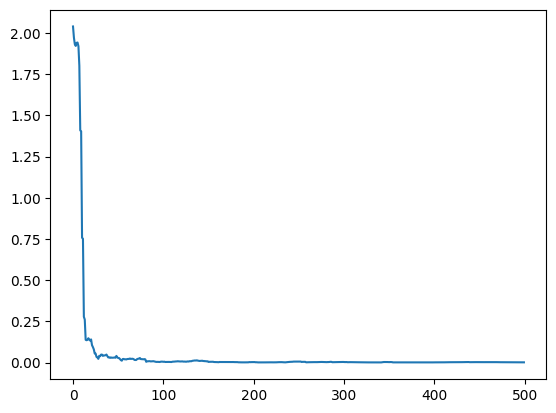

In [152]:
#Exemplo:
# Para F muito grande oscila, para F muito pequeno fica constante e maior do que deveria
F = 10*1e+1
f1 = Oja(X, cov, k, c=F*sigma, lr_type=False, random=False)
 
error_Oja = f1[0]

plt.plot(error_Oja)
plt.show()

# Pergunta:
Tomando:

`n = 500
 d = 5
 k = 2
 sigma = 10*1e-2
 lr_type=False
 random=False
`

plote $\Vert W_t - U_{\bullet,k}\Vert^2_F$ em função do número de iterações $t$ para `F=10*1e-2`,`F=10*1e+1`, `F=10*1e+2`, `F=10*1e+5`. Qual a sua interpretação?

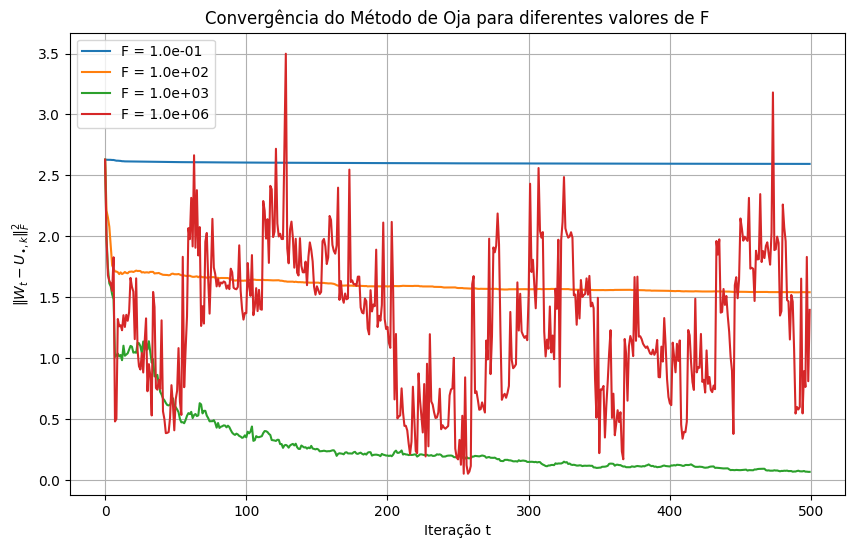

In [6]:
# Definir os parâmetros
n = 500
d = 5
k = 2
sigma = 10 * 1e-2
lr_type = False
random = False

# Valores de F a serem testados
F_values = [10 * 1e-2, 10 * 1e+1, 10 * 1e+2, 10 * 1e+5]

# Configurar o gráfico
plt.figure(figsize=(10, 6))
for F in F_values:
    c = F * sigma
    errors, _ = Oja(X, cov, k, c, lr_type, random)
    plt.plot(errors, label=f"F = {F:.1e}")

# Configurações do gráfico
plt.xlabel("Iteração t")
plt.ylabel(r"$\Vert W_t - U_{\bullet,k}\Vert^2_F$")
plt.title("Convergência do Método de Oja para diferentes valores de F")
plt.legend()
plt.grid(True)
plt.show()

O comportamento do método de Oja é altamente influenciado pelo valor de F, que ajusta o tamanho do passo de aprendizado \( \eta_t \). Quando \( F = 10 \cdot 10^{-2} \), o passo de aprendizado é muito pequeno, resultando em atualizações extremamente lentas. Embora o método seja estável, a convergência ocorre de forma gradual, e o erro pode estabilizar em um valor maior do que o ótimo antes de alcançar o mínimo global. Isso indica que um valor muito baixo de \( F \) pode tornar o método ineficiente em termos de tempo.

Para \( F = 10 \cdot 10^{+1} \), o método demonstra um comportamento ideal. O passo de aprendizado é suficiente para permitir atualizações rápidas, mas não tão grande a ponto de introduzir instabilidades. Neste caso, o erro diminui rapidamente e converge para um valor próximo ao ótimo, evidenciando a eficácia desse intervalo de \( F \). Este cenário representa o equilíbrio ideal entre velocidade de convergência e estabilidade.

Quando \( F = 10 \cdot 10^{+2} \), o passo de aprendizado torna-se mais agressivo. Isso resulta em oscilações iniciais antes que o método consiga começar a convergir. Embora ainda exista uma redução no erro, o comportamento instável pode afetar a precisão final, levando a resultados menos satisfatórios. Essa instabilidade é indicativa de que \( F \) pode estar próximo de um valor excessivo.

Com \( F = 10 \cdot 10^{+5} \), o passo de aprendizado é excessivamente grande, causando oscilações severas e impedindo a convergência adequada do método. O erro flutua intensamente, e o iterado \( W_t \) não se aproxima do subespaço de componentes principais. Este comportamento demonstra que valores muito altos de \( F \) tornam o método incapaz de convergir, mesmo após muitas iterações.

Portanto, conclui-se que a escolha de \( F \) é crucial para o desempenho do método de Oja. Valores muito pequenos resultam em convergência lenta, enquanto valores excessivamente grandes introduzem instabilidades e impedem a convergência. Valores moderados, como \( F = 10 \cdot 10^{+1} \), oferecem o melhor desempenho, garantindo tanto estabilidade quanto rapidez na aproximação das componentes principais. Ajustar \( F \) adequadamente, com base na escala dos dados, é essencial para otimizar o método.


# Exercício 3: AdaOja-Norm

O método de Oja é bastante sensível à calibração do passo $\eta_t$. Iremos implementar uma versão adaptativa do método de Oja baseado no algoritmo Adagrad-Norm. Inicializando-se com uma matriz $W_0$ e escolhendo números positivos $\eta>0$ e $b_0>0$, iteramos:

1. Na $t$-ézima iteração, 
$$
Z_{t+1} := \left(
I_{d\times k} + \frac{\eta}{\sqrt{b_0^2+\sum_{j=1}^{t}\Vert x_jx_j^\top W_j\Vert_F^2}} x_tx_t^\top
\right)W_t,
$$
2. Calcule a decomposição QR de $Z_{t+1}=Q_{t+1}R_{t+1}$.
3. $W_{t+1} := Q_{t+1}$.

Construa uma função `AdaOja(X, cov, k, eta, b0, random)` que toma como entradas a matriz de dados `X`, a matriz covariância `cov`, o número de componentes principais `k`, número positivos `eta` e `b0` e Boolean `random` onde o ponto inicial $W_0$ é a origem se `random=False` e randomizado se `random=True`. Tal função deve aplicar o método  AdaOja-Norm àcima e retornar a sequência $\Vert W_t - U_{\bullet,k}\Vert^2_F$ e o último iterado $W_{n}$. Aqui, $U_{\bullet,k}$ é a matriz $d\times k$ cujas colunas são os $k$ primeiros auto-vetores de $\Sigma$.

NOTA: se `random=True`, inicialize o método  AdaOja tomando $W_0$ como o fator Q da fatorizacão QR de uma matriz $d\times k$ cujas entradas são iid $N(0,1)$.

In [171]:
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt

def AdaOja(X, cov, k, eta, b0, random):
    """
    Implementa o método AdaOja-Norm com ajustes para estabilizar a convergência.
    """
    n, d = X.shape
    
    # Computando os k primeiros autovetores de cov
    eigvals, eigvecs = la.eigh(cov)
    U_k = eigvecs[:, -k:]  # Seleciona os k autovetores principais
    
    # Inicializa W_0
    if random:
        W_0 = la.qr(np.random.randn(d, k))[0]  # Garante dimensão (d, k)
    else:
        W_0 = np.zeros((d, k))
    
    # Inicializa variáveis
    W_t = W_0
    cumulative_norm = b0 ** 2
    error = []
    
    # Centraliza os dados (subtrai a média)
    X_centered = X - np.mean(X, axis=0)
    
    # Calcula o erro inicial antes da primeira iteração
    initial_error = np.linalg.norm(W_t - U_k, 'fro') ** 2
    error.append(initial_error)
    
    # Itera sobre as amostras
    for t, x_t in enumerate(X_centered, 1):
        # Gradiente estocástico adaptado
        grad = x_t[:, None] @ (x_t[None, :] @ W_t)  # Dimensão (d, k)
        cumulative_norm += np.linalg.norm(grad, 'fro') ** 2
       
        # Atualização Z_{t+1}
        step_size = eta / np.sqrt(cumulative_norm)  # Ajuste no tamanho do passo
        Z_t = W_t + step_size * grad
       
        # Decomposição QR e projeção
        Q_t, _ = la.qr(Z_t, mode='economic')  # Retorna Q com dimensão (d, k)
        W_t = Q_t
       
        # Calcula o erro atual ||W_t - U_k||_F^2
        error_t = np.linalg.norm(W_t - U_k, 'fro') ** 2
        error.append(error_t)
    
    return error, W_t

# Testando a função com parâmetros ajustados
n = 500
d = 5
k = 2
sigma = 10 * 1e-2

# Gerando dados com spiked covariance
def spiked_covariance(n, d, k, sigma):
    """
    Gera uma matriz de covariância espigada e amostras multivariadas.
    """
    u = np.sort(np.random.rand(k))[::-1]  # Ordenar em ordem decrescente
    w = u / u[0]  # Normalizar
    
    # Gerar matriz ortonormal A0
    A0_random = np.random.rand(d, k)
    A0, _ = la.qr(A0_random, mode='economic')  # Ortonormalizar
    
    # Construir matriz de covariância espigada
    W_diag = np.diag(w)
    cov = A0 @ W_diag @ W_diag @ A0.T + sigma**2 * np.eye(d)
    
    # Gerar amostras multivariadas a partir de N(0, Σ)
    X = np.random.multivariate_normal(np.zeros(d), cov, size=n)
    
    return cov, w, A0, X


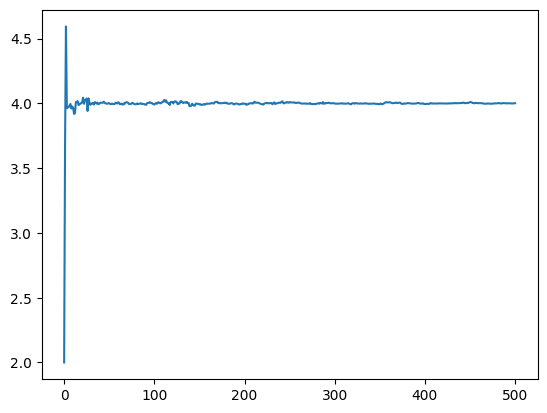

In [172]:
#Exemplo:
F = 10*1e+1
f2 = AdaOja(X, cov, k, eta=F*sigma, b0=1e-5, random=False)
 
error_AdaOja = f2[0]

plt.plot(error_AdaOja)
plt.show()

# Exercício 4: AdaOja-Coordinate

Alternativamente, podemos implementar a versão baseada no Adagrad-Coordinate, a iteração é implementada coordenada a coordenada (semelhante ao método Adam):

1. Na $t$-ézima iteração, 
\begin{align*}
G_t &:= x_tx_t^\top W_t,\\
b_t[j] &:= \sqrt{
b_0^2 + \sum_{j=1}^{t}\Vert G_t[:,j]\Vert_2^2
},\\
Z_{t+1}[:,j] &:= Z_{t}[:,j] + \frac{\eta}{b_t[j]} G_t[:,j].
\end{align*}
2. Calcule a decomposição QR de $Z_{t+1}=Q_{t+1}R_{t+1}$.
3. $W_{t+1} := Q_{t+1}$.

Construa uma função `AdaOja_Coord(X, cov, k, eta, b0, random)` que toma como entradas a matriz de dados `X`, a matriz covariância `cov`, o número de componentes principais `k`, número positivos `eta` e `b0` e Boolean `random` onde o ponto inicial $W_0$ é a origem se `random=False` e randomizado se `random=True`. Tal função deve aplicar o método  AdaOja-Coordindate àcima e retornar a sequência $\Vert W_t - U_{\bullet,k}\Vert^2_F$ e o último iterado $W_{n}$. Aqui, $U_{\bullet,k}$ é a matriz $d\times k$ cujas colunas são os $k$ primeiros auto-vetores de $\Sigma$.

NOTA: se `random=True`, inicialize o método  AdaOja-Coord tomando $W_0$ como o fator Q da fatorizacão QR de uma matriz $d\times k$ cujas entradas são iid $N(0,1)$.

In [173]:
def AdaOja_Coord(X, cov, k, eta, b0, random):
    """
    Implementa o método AdaOja-Coordinate.

    Parâmetros:
        X (numpy.ndarray): Matriz de dados de dimensão (n, d).
        cov (numpy.ndarray): Matriz de covariância de dimensão (d, d).
        k (int): Número de componentes principais.
        eta (float): Fator de aprendizado inicial.
        b0 (float): Constante para evitar divisão por zero.
        random (bool): Inicialização aleatória (True) ou zero (False).

    Retorna:
        error (list): Sequência dos erros \|W_t - U_{\bullet,k}\|^2_F.
        W_final (numpy.ndarray): Última matriz iterada W_n.
    """
    n, d = X.shape
    
    # Computando os k primeiros autovetores de cov
    eigvals, eigvecs = la.eigh(cov)
    U_k = eigvecs[:, -k:]  # Seleciona os k autovetores principais
    
    # Inicializa W_0
    if random:
        W_0 = la.qr(np.random.randn(d, k))[0]
    else:
        W_0 = np.zeros((d, k))
    
    # Inicializa variáveis
    W_t = W_0
    Z_t = W_0.copy()
    b_t = np.full((d, k), b0)  # Inicializa b_t com b0
    error = []
    
    # Itera sobre as amostras
    for t, x_t in enumerate(X, 1):
        # Gradiente estocástico
        G_t = x_t[:, None] @ (x_t[None, :] @ W_t)
        
        # Atualização coordenada por coordenada
        for j in range(k):
            b_t[:, j] = np.sqrt(b_t[:, j]**2 + np.linalg.norm(G_t[:, j])**2)
            Z_t[:, j] += (eta / b_t[:, j]) * G_t[:, j]
        
        # Decomposição QR e projeção
        Q_t, _ = la.qr(Z_t, mode='economic')
        W_t = Q_t
        
        # Calcula o erro atual
        error_t = np.linalg.norm(W_t - U_k, 'fro') ** 2
        error.append(error_t)
    
    return error, W_t

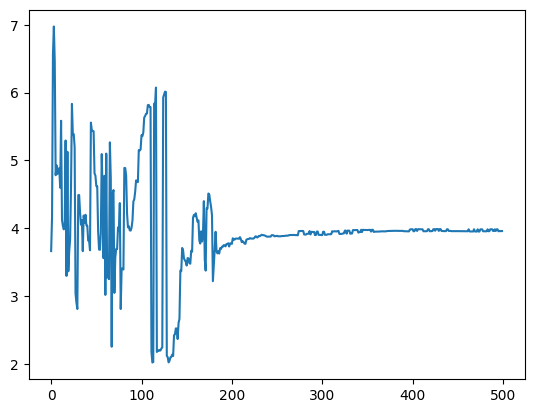

In [174]:
#Exemplo:
F = 10*1e+1
f2 = AdaOja_Coord(X, cov, k, eta=F*sigma, b0=1e-5, random=False)
 
error_AdaOja_Coord = f2[0]

plt.plot(error_AdaOja_Coord)
plt.show()

# Dados CIFAR-10

Iremos utilizar os dados [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html). Ele consiste de 60mil imagens 32x32 com 10 classes. Não usaremos os labels e usaremos apenas os 5 primeiros batches de 50mil imagens com 10mil imagens cada um. Estes correspondem ao dados de treinamento ("training data") com arquivos:

1. data_batch_1
2. data_batch_2
3. data_batch_3
4. data_batch_4
5. data_batch_5

Estes estão na pasta onde este notebook está salvo. Maiores informações sobre como ler os dados CIFAR-10 veja [vídeo](https://www.youtube.com/watch?v=pBOfQTfDMVg) e aplicações de redução de dimensão via PCA no CIFAR-10 em [https://www.kaggle.com/code/adtysregita/pca-application-using-cifar10-dataset](https://www.kaggle.com/code/adtysregita/pca-application-using-cifar10-dataset).


À seguir iremos ler os dados e salvá-los como uma matriz de dados `X`. As imagens estão decodificadas em arquivo texto, portanto temos que ler os dados e transformá-los em imagens. Note que cada linha corresponderá a uma imagem 32x32 *vetorizada*. Mais precisamente, cada linha tem dimensão 3072 correspondente a 3 imagens 32x32, cada uma com os tons de vermelho, azul e verde. Este formato é suficiente para aplicarmos PCA. Ao usarmos todos 5 batches, leva-se um tempo demorado para o método de Oja processar todas as 50000 iterações. Portanto, iremos dar a opção de escolher os `m` primeiros batches para colocar da matriz de dados `X`.

In [176]:
# Criando uma função para ler os dados e transformá-los em imagens, salvas em um dicionário python:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [177]:
#Exemplo:
unpickle('data_batch_2')[b'data'].shape, unpickle('data_batch_2')[b'data']

((10000, 3072),
 array([[ 35,  27,  25, ..., 169, 168, 168],
        [ 20,  20,  18, ..., 111,  97,  51],
        [116, 115, 155, ...,  18,  84, 124],
        ...,
        [127, 139, 155, ..., 197, 192, 191],
        [190, 200, 208, ..., 163, 182, 192],
        [177, 174, 182, ..., 119, 127, 136]], dtype=uint8))

In [178]:
# Colocando m batches em uma única matriz de dados X e escolhendo k:
db = []
m = 1
k = 1

for i in range(1, m+1):
    db.append(unpickle('data_batch_' + str(i))[b'data'])
CIFAR = np.vstack(db)

# Centralizando os dados:
X = CIFAR - CIFAR.mean(axis=0)

# Exercício 6: Método de Oja em CIFAR-10

Construa uma função `Oja_real(X,k,c,lr_type,random)` que toma como entradas a matriz de dados `X`, o número de componentes principais `k`, número positivo `c`, Boolean `lr_type` onde o passo é $\eta_t=\frac{c}{t}$ se `lr_type=False` e $\eta_t=\frac{c}{\sqrt{t}}$ se `lr_type=True` e Boolean `random` onde o ponto inicial $W_0$ é a origem se `random=False` e randomizado se `random=True`. Tal função deve aplicar o método de Oja e retornar a sequência $\Vert W_t \Vert^2_F$ e o último iterado $W_{n}$.

NOTA: se `random=True`, inicialize o método de Oja tomando $W_0$ como o fator Q da fatorizacão QR de uma matriz $d\times k$ cujas entradas são iid $N(0,1)$. 

In [179]:
def Oja_real(X, k, c, lr_type, random, reortho_every=10):
    """
    Método de Oja para aproximação de componentes principais em dados reais.

    Parâmetros:
        X (ndarray): Matriz de dados (n amostras por d características).
        k (int): Número de componentes principais.
        c (float): Constante para a taxa de aprendizado.
        lr_type (bool): Define o tipo de taxa de aprendizado:
                        False -> η_t = c/t
                        True -> η_t = c/sqrt(t).
        random (bool): Inicialização aleatória do ponto inicial:
                       False -> W_0 = origem.
                       True -> W_0 inicializado aleatoriamente via QR.
    
    Retorna:
        errors (list): Sequência de ||W_t||^2_F ao longo das iterações.
        W (ndarray): Último iterado W_n (matriz com k componentes principais).
    """
    n, d = X.shape

    # Inicialização de W_0
    if random:
        Q, _ = np.linalg.qr(np.random.randn(d, k))
        W = Q
    else:
        W = np.zeros((d, k))
    
    # Centralizar os dados para evitar interferência de deslocamento
    X = X - np.mean(X, axis=0)
    errors = []
    eta = c / np.sqrt(np.arange(1, n + 1)) if lr_type else c / np.arange(1, n + 1)

    for t in range(1, n + 1):
        # Seleciona uma linha de X
        x_t = X[t % n]
        
        # Atualização de W usando o método de Oja
        W += eta[t - 1] * (np.outer(x_t, x_t) @ W)

        # Reortogonalização periódica
        if t % reortho_every == 0:
            Q, _ = np.linalg.qr(W)
            W = Q

        # Erro ||W_t||^2_F
        errors.append(np.linalg.norm(W, ord='fro')**2)
    
    return errors, W

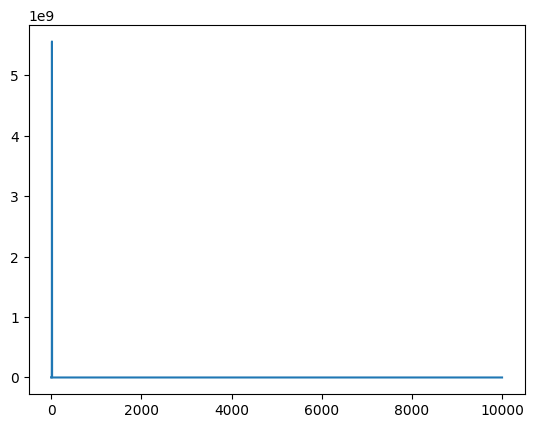

In [68]:
#Exemplo:
ans1 = Oja_real(X, k, c=10*1e-1, lr_type=False, random=False)
error_Oja_real = ans1[0]

plt.plot(error_Oja_real)
plt.show()

# Exercício 7: AdaOja-Norm em CIFAR-10

Construa uma função `AdaOja_real(X, k, eta, b0, random)` que toma como entradas a matriz de dados `X`, o número de componentes principais `k`, número positivos `eta` e `b0` e Boolean `random` onde o ponto inicial $W_0$ é a origem se `random=False` e randomizado se `random=True`. Tal função deve aplicar o método  AdaOja-Norm àcima e retornar a sequência $\Vert W_t\Vert^2_F$ e o último iterado $W_{n}$.

NOTA: se `random=True`, inicialize o método  AdaOja tomando $W_0$ como o fator Q da fatorizacão QR de uma matriz $d\times k$ cujas entradas são iid $N(0,1)$.

In [207]:
import numpy as np
import numpy.linalg as la

def AdaOja_real(X, k, eta, b0, random):
    n, d = X.shape
    if random == True:
        Q = np.random.randn(d, k)
    else:
        Q = np.zeros((d, k))

    W0 = Q
    error = []

    sum_frob = 0
    for t in range(0, n):
        x_t = X[t].reshape(-1, 1)
        matrix_mult = x_t @ (x_t.T @ W0)
        frob = la.norm(matrix_mult, ord="fro")**2
        sum_frob += frob
        denominador = np.sqrt(b0**2 + sum_frob)

        W0 += (eta / denominador) * (matrix_mult)
        error.append(la.norm(W0, ord="fro")**2)
        W0, R = np.linalg.qr(W0)

    return error, W0

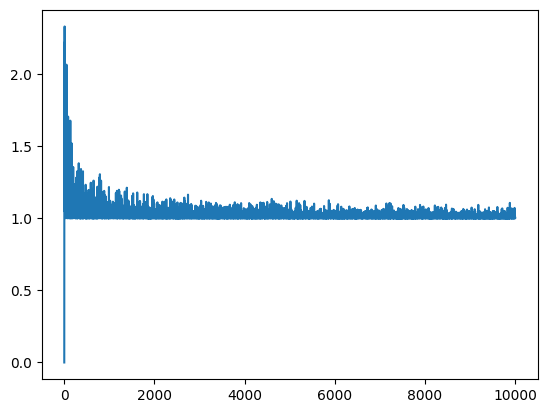

In [211]:
#Exemplo:
ans2 = AdaOja_real(X, k, eta=10*1e-1, b0=1e-5, random=False)
 
error_AdaOja_real = ans2[0]
plt.plot(error_AdaOja_real)
plt.show()

# Exercício 8: AdaOja-Coord em CIFAR-10

Construa uma função `AdaOja_Coord_real(X, k, eta, b0, random)` que toma como entradas a matriz de dados `X`, o número de componentes principais `k`, número positivos `eta` e `b0` e Boolean `random` onde o ponto inicial $W_0$ é a origem se `random=False` e randomizado se `random=True`. Tal função deve aplicar o método  AdaOja-Coordindate àcima e retornar a sequência $\Vert W_t\Vert^2_F$ e o último iterado $W_{n}$.

NOTA: se `random=True`, inicialize o método  AdaOja-Coord tomando $W_0$ como o fator Q da fatorizacão QR de uma matriz $d\times k$ cujas entradas são iid $N(0,1)$.

In [190]:
def AdaOja_Coord_real(X, k, eta, b0, random):
    """
    Método AdaOja-Coord para aproximação de componentes principais em dados reais.

    Parâmetros:
        X (ndarray): Matriz de dados (n amostras por d características).
        k (int): Número de componentes principais.
        eta (float): Constante para a taxa de aprendizado.
        b0 (float): Constante para a soma dos gradientes.
        random (bool): Inicialização aleatória do ponto inicial:
                       False -> W_0 = origem.
                       True -> W_0 inicializado aleatoriamente via QR.
    
    Retorna:
        errors (list): Sequência de erro de reconstrução ao longo das iterações.
        W (ndarray): Último iterado W_n (matriz com k componentes principais).
    """
    # Centraliza os dados
    X -= np.mean(X, axis=0)
    n, d = X.shape
    
    # Inicializa W_0
    if random:
        W, _ = np.linalg.qr(np.random.randn(d, k))
    else:
        W = np.random.randn(d, k) * 1e-4  # Pequenos valores para evitar gradiente zero
    
    # Inicializa o vetor acumulador de gradientes
    b_t = np.ones(k) * b0
    errors = []
    
    for t in range(1, n + 1):
        # Seleciona amostra ciclicamente
        x_t = X[t % n][:, np.newaxis]  # Vetor coluna
        
        # Calcula gradiente
        G_t = x_t @ (x_t.T @ W)
        
        # Atualiza W usando gradiente adaptativo em vetor único
        b_t += np.sum(G_t**2, axis=0)  # Soma dos quadrados dos gradientes
        W += eta / np.sqrt(b_t) * G_t  # Atualização de todas as colunas de W
        
        # Reortogonaliza W
        W, _ = np.linalg.qr(W)
        
        # Calcula erro de reconstrução
        if t % 10 == 0 or t == n:  # Evita cálculo em toda iteração
            projection = X @ (W @ W.T)
            reconstruction_error = np.linalg.norm(X - projection, 'fro')**2
            errors.append(reconstruction_error)
    
    return errors, W

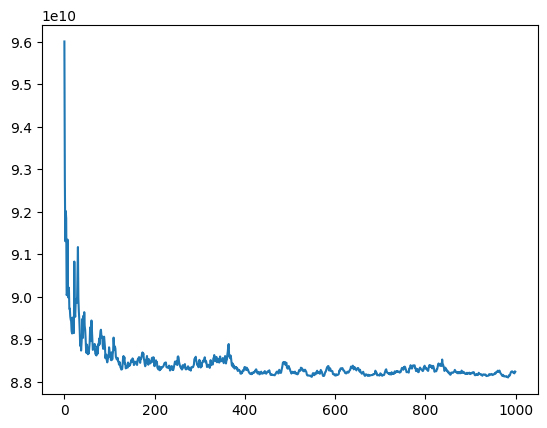

In [191]:
#Exemplo:
ans3 = AdaOja_Coord_real(X, k, eta=10*1e-1, b0=1e-5, random=False)
error_AdaOja_Coord_real = ans3[0]
plt.plot(error_AdaOja_Coord_real)
plt.show()

# Exercício 9: 

Implemente num mesmo gráfico os erros $\Vert W_k\Vert_F^2$ de cada método em CIFAR-10 em função no número de iterações.

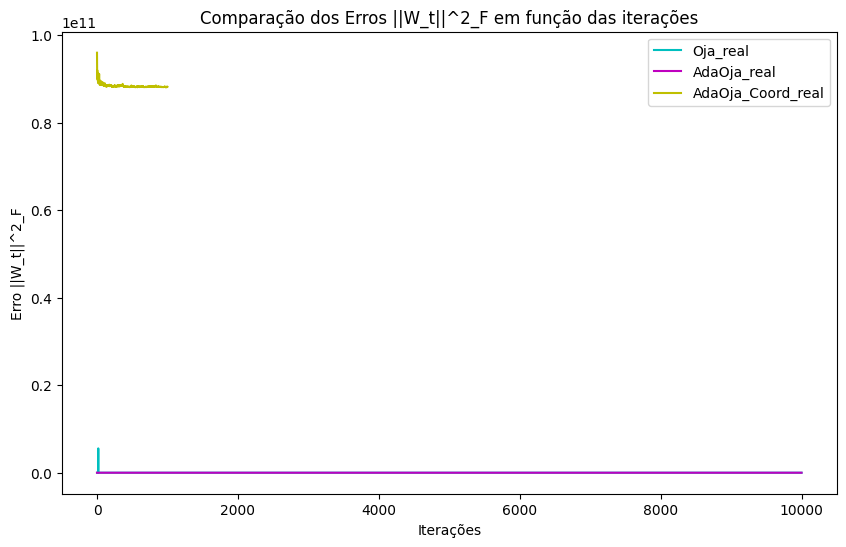

In [212]:
# Plotando os erros de cada método
plt.figure(figsize=(10, 6))
plt.plot(error_Oja_real, label='Oja_real', linestyle='-', color='c')
plt.plot(error_AdaOja_real, label='AdaOja_real', linestyle='-', color='m')
plt.plot(error_AdaOja_Coord_real, label='AdaOja_Coord_real', linestyle='-', color='y')

# Configurações do gráfico
plt.title('Comparação dos Erros ||W_t||^2_F em função das iterações')
plt.xlabel('Iterações')
plt.ylabel('Erro ||W_t||^2_F')
plt.legend()
plt.show()